## Cleaning

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
nltk.download('stopwords')
from gensim.utils import tokenize
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from collections import OrderedDict
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
# our code
import preprocessing
import manage_results
import training_tools

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alessio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We started with [this](https://www.kaggle.com/shivamb/go-emotions-google-emotions-dataset) initial dataset, and with the following code we: removed unclear samples, removed duplicated samples, removed useless columns, removed punctuation and computed the ground truths to predict:

In [3]:
DATASET_PATH = "go_emotions_dataset.csv" # original dataset path

def basicprocessing(path):
    df = pd.read_csv(path)
    df.drop_duplicates(subset="text", inplace=True) # remove duplicated comments
    df = df[df["example_very_unclear"] == False].drop(["id","example_very_unclear"], axis="columns") # keep only clear comments and remove unnecessary columns

    punctuation = str.maketrans('', '', string.punctuation) # dict with punctuation to remove (the key is the ASCII code of the char)
    for x,y in zip(range(8216,8232), range(8242,8248)): # adding some other non-conventional unicode punctuation char codes to remove
        punctuation[x] = None
        punctuation[y] = None

    df["text"] = df['text'].str.translate(punctuation) # punctuation removal

    # sentiment index : sentiment group
    sent_dict = {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 2, 7: 2, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1, 15: 0, 16: 1, 
                17: 0, 18: 0, 19: 1, 20: 0, 21: 0, 22: 2, 23: 0, 24: 1, 25: 1, 26: 2, 27: 2}

    def create_y(row):
        counts = np.zeros(3) # 0 = positive, 1 = negative, 2 = neutral
        indexes = np.where(row == 1)[0]
        for idx in indexes:
            counts[sent_dict[idx]] += 1
        return np.argmax(counts)

    df["y"] = df.iloc[:,1:].apply(lambda x: create_y(x), axis=1) # reduce the y to predict from 28 fine-grained emotions to 3 emotions
    df.drop(df.columns[1:-1], axis="columns", inplace=True)

    return df


df = basicprocessing(DATASET_PATH)
df.head()

,text,y
0,That game hurt,1
2,You do right if you dont care then fuck em,2
3,Man I love reddit,0
4,NAME was nowhere near them he was by the Falcon,2
5,Right Considering its such an important docume...,0


Run the following code if you want to make everything lowercase:

In [5]:
preprocessing.lower_case(df)    
df.head()

,text,y
0,that game hurt,1
1,you do right if you dont care then fuck em,2
2,man i love reddit,0
3,name was nowhere near them he was by the falcon,2
4,right considering its such an important docume...,0


### Exploring the dataset

In this little section we want to visualize how the words are distributed across the three classes and analyzing how often they are met in the dataframe.

In order to understand which choises we can make about these words let's proceed by step and first analyze the distribution of the words by one word cloud for each class to make visually clear what's going on inside our comments.


In [6]:
from wordcloud import WordCloud

# Let's group the words of the same class in the same group
def group_and_filter(df, no_words=[]):
    '''
        Given a dataframe and a blacklist of words, returns a grouped dataframe (by the 'y' column)
        that contains in each group a string made by all the words of that class
    '''

    grouped_txt = df.groupby(by='y').agg({'text': lambda txt: ' '.join([s for t in txt for s in t.split(' ') if s.lower() not in no_words])})
    return grouped_txt

grouped_txt = group_and_filter(df, ['name', 'religion', 'people', 'look', 'im', 'think', 'think','one'])
grouped_txt

,text
y,
0,man i love reddit right considering its such a...
1,that game hurt he isnt as big but hes still qu...
2,you do right if you dont care then fuck em was...


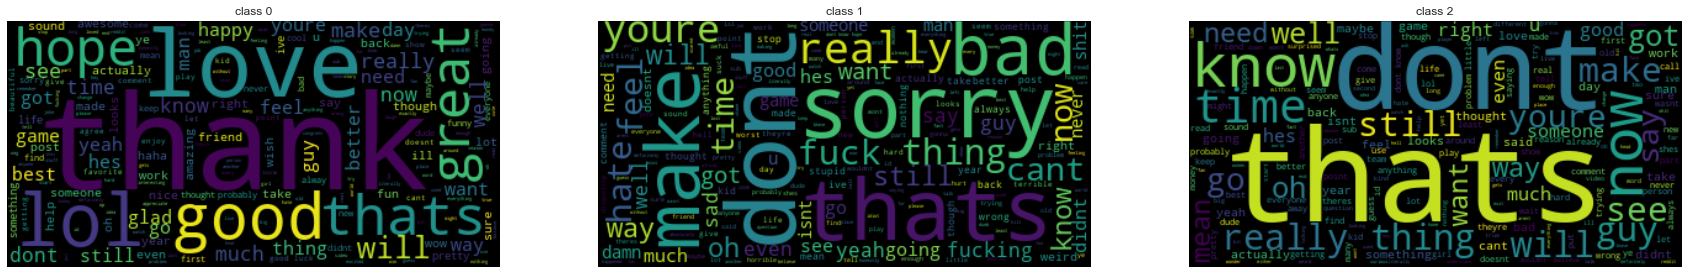

In [10]:
wc = WordCloud()
fig, ax = plt.subplots(1, 3, figsize=(30,10))
for i in range(3):
    wc.generate_from_text(grouped_txt.iloc[i].values[0])
    ax[i].imshow(wc, interpolation="bilinear")
    ax[i].set_title(f"class {i}")
    ax[i].axis('off')
    ax[i].grid(b=None)

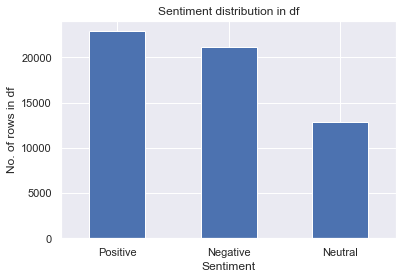

In [11]:
plt.figure()
pd.value_counts(df["y"]).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.xticks([0,1,2], labels=["Positive","Negative","Neutral"], rotation="horizontal")
plt.ylabel("No. of rows in df")
plt.show()

#### Going numeric...


Now that we've seen where and how the word are in the dataset, let's translate this information in numbers.<br>
In the following cell we've obtained a pandas Serie that has as index a word and as value the number of occurrencies among the entire dataset in order to understand which word mantain and which drop.


After having grouped the words in this way we've plotted the distribution of these words and filled the most interesting words (the words that occours more than 4 times), in fact, for example in the idf formulas the words that appears a minor number of times have a bigger value of $idf$, but the  words (and we'll see that they are so many) that appears in more than 55k documents only 4 times will have a big idf value and it's true, but if they appear so rarely they can't give us much information to learn when their presence is good and when it is not.<br>
This data is comed out when we've done the first tests where training over the entire dataset and over the filtered one doesn't change the results, but has restricted the space of the word from a magnitude of 30k words to less then 10k, this brought a huge speed up, so all the tests are done filtering out the less frequent words.

In [12]:
word_freq = pd.Series(' '.join(df['text']).split()).value_counts()
word_freq

the              23779
i                21398
to               16813
a                16418
you              13031
                 ...  
flogging             1
simmonds             1
gratification        1
🤪🌹                   1
gazillion            1
Length: 33357, dtype: int64

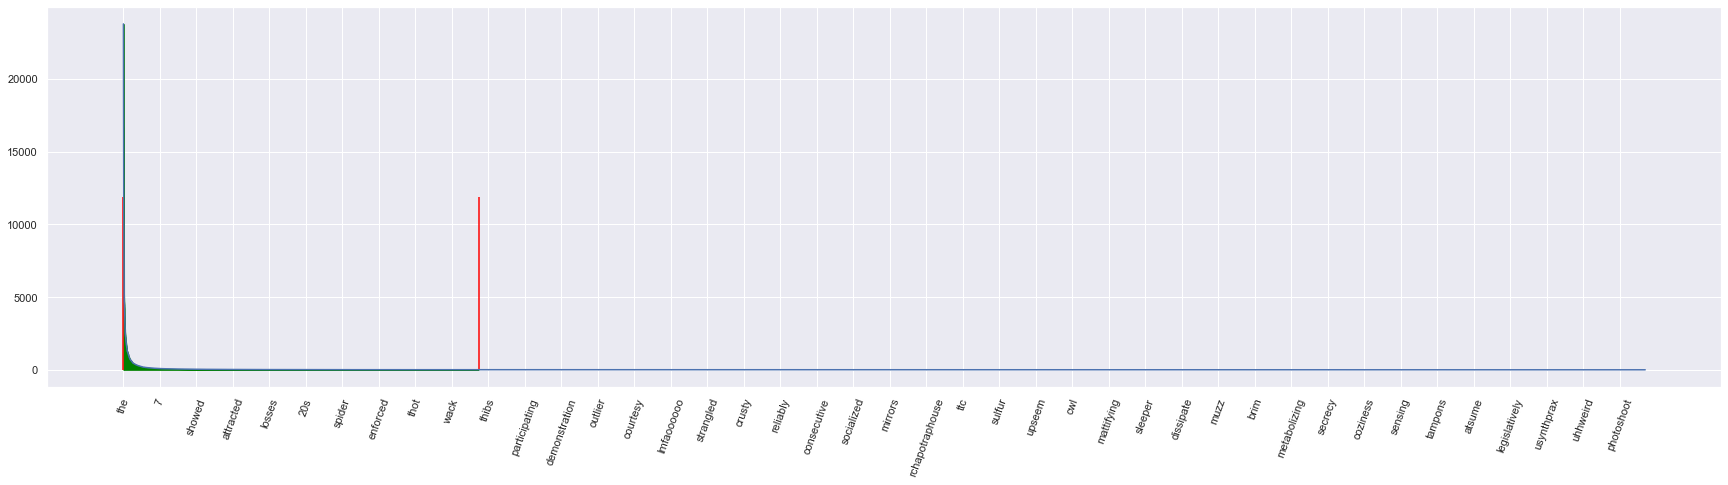

In [15]:
fig, ax = plt.subplots(figsize=(30,7))

# plotting the frequencies
ax.plot(np.arange(len(word_freq)), word_freq.values)

# setting up the labels
tk = plt.xticks(ticks= np.arange(0,len(word_freq), 800), labels=word_freq.index[np.arange(0,len(word_freq), 800)], rotation=70)

# finding the cut-off point
start, end = (0, np.where(word_freq.values<5)[0][0])
ax.vlines([start, end], [0, 0], [word_freq.values.max()/2, word_freq.values.max()/2], colors=['red', 'red'])

# visualizing the mean number of occurrencies
# ax.hlines(5,-1, len(word_freq),colors='red')

# adding a little bit of colour
ax.fill_between(np.arange(end), 0, word_freq.values[np.arange(end)], color='green')


In [16]:
for i in range(0, 10000, 500):
    print(f"n_words that occours more than {i}: {len(word_freq[word_freq.values>i])}")

n_words that occours more than 0: 33357
n_words that occours more than 500: 200
n_words that occours more than 1000: 111
n_words that occours more than 1500: 76
n_words that occours more than 2000: 53
n_words that occours more than 2500: 41
n_words that occours more than 3000: 35
n_words that occours more than 3500: 31
n_words that occours more than 4000: 28
n_words that occours more than 4500: 23
n_words that occours more than 5000: 16
n_words that occours more than 5500: 14
n_words that occours more than 6000: 14
n_words that occours more than 6500: 14
n_words that occours more than 7000: 14
n_words that occours more than 7500: 14
n_words that occours more than 8000: 12
n_words that occours more than 8500: 12
n_words that occours more than 9000: 11
n_words that occours more than 9500: 10


In [17]:
for i in range(0, 50, 5):
    print(f"n_words that occours less than {i}: {len(word_freq[word_freq.values<i])}")

n_words that occours less than 0: 0
n_words that occours less than 5: 25574
n_words that occours less than 10: 28762
n_words that occours less than 15: 29999
n_words that occours less than 20: 30674
n_words that occours less than 25: 31086
n_words that occours less than 30: 31395
n_words that occours less than 35: 31625
n_words that occours less than 40: 31791
n_words that occours less than 45: 31925


In [18]:
old_len = len(word_freq)
word_freq= word_freq[(word_freq>4)]
print(f"new length of the embedded vector: {len(word_freq)} saved {old_len} position ({round((old_len-len(word_freq))/old_len*100,2)}% of space)")

new length of the embedded vector: 7783 saved 33357 position (76.67% of space)


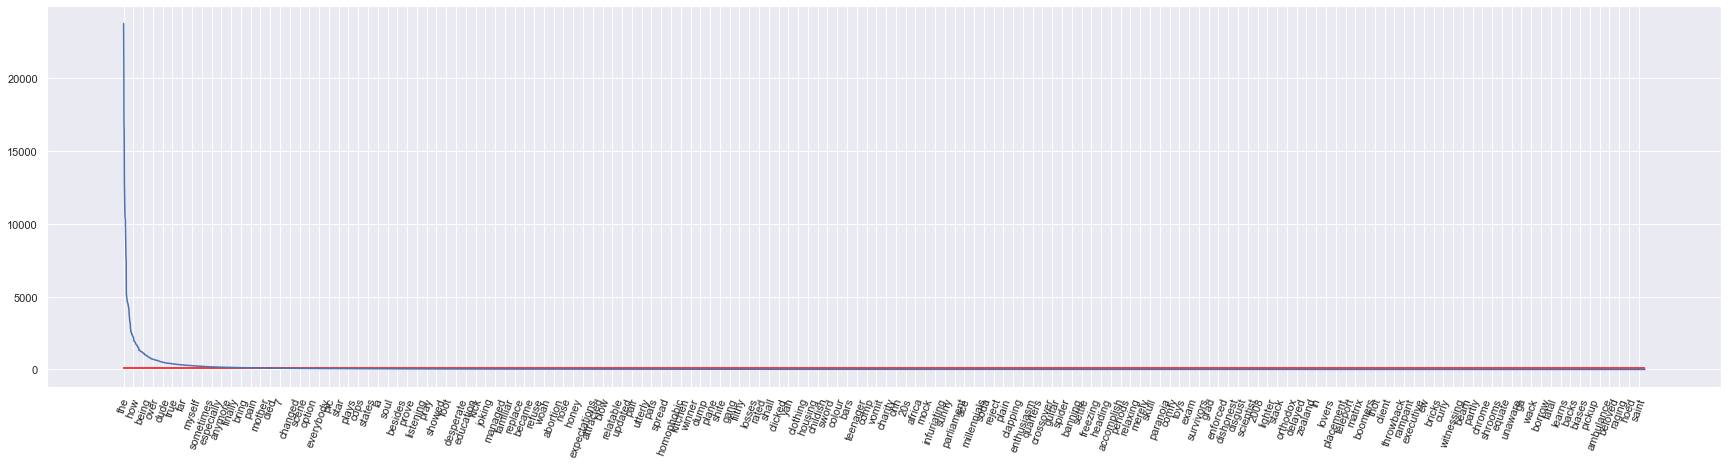

In [19]:
# Visualizing the NEW word_freq distribution
fig, ax = plt.subplots(figsize=(30,7))
ax.plot(np.arange(len(word_freq)), word_freq.values)
ax.hlines(word_freq.values.mean(),-1, len(word_freq),colors='red')
tk = plt.xticks(ticks= np.arange(0,len(word_freq), 50), labels=word_freq.index[np.arange(0,len(word_freq), 50)], rotation=70)
tk_y = plt.yticks

## Preprocessing of the dataset
In the following cells it's shown the processes of removing the stopwords, the lemmatization and the removing of the less frequent words in the given dataset.

Run the following code if you want to remove stopwords:

In [20]:
preprocessing.remove_stopwords(df)
df.head()

,text,y
0,game hurt,1
1,right dont care fuck em,2
2,man love reddit,0
3,name nowhere near falcon,2
4,right considering important document know damn...,0


Run the following code if you want to remove less frequent words:

In [ ]:
df = preprocessing.remove_lessfreq(df)
df.head(15)

Run the following code if you want to do lemmatization. **NOTE:** Lemmatization always implies lowercasing:

In [ ]:
preprocessing.lemmatize(df)

In [23]:
df.head(15)

,text,y
0,game hurt,1
1,right do not care fuck em,2
2,man love reddit,0
3,name nowhere near,2
4,right consider important document know damn th...,0
5,be not big he s still quite popular I ve hear ...,1
6,that s crazy go super religion high school thi...,0
7,that s adorable,0
8,pub haha ha aaa finale real,0
9,mention think that s trigger nostalgia,2


--------------------------------------------------------------------------------------------------------------

As anticipated in the report we'll try three types of embedding on the same dataset with preprocessing configurations.<br>
Since the results are already discussed in the report we'll show only one execution of the code just for sake of example.

# TF-IDF (term frequency-inverse document frequency)
The [theory](https://monkeylearn.com/blog/what-is-tf-idf/):
Says that this tecnique computes how much a single word is important in a document with respect to the frequency whith which this word has occourring in all other documents
It's the product of:
* **Term frequency** in the specific document
* **Inverse document frequency** among all the documents

## Formulas

Given the following parameters:
* $t$ the **term**
* $d$ the **document**
* $D$ the **total documents**
* $N$ the **total number of words**

So we'll compute:
\begin{equation}
    TF-IDF(t, d | D) = tf(t, d) \cdot idf(t, D)
\end{equation}
Where:
\begin{equation}
    tf(t, d) = \frac{\sum_{t_i \in d}1(t_i=t)}{|d|}
\end{equation}
And:
\begin{equation}
    idf(t, D) = log(\frac{|D|}{\sum_{d}1(t \in d)})
\end{equation}

As can be intuitively seen these formulas are applied to each term of each documents, so for each document $d$ we'll have a vector that contains for each term the TF-IDF value.

## Final form:

Suppose to have $N$ total words, so for each documents we'll have a 1-D vector of lenght N where for each position i we'll have the the TF-IDF value of the i-th term of our vocabulary in that document, of course if the term doesn't occour in the document it'll value 0.

In [25]:
STOPWORDS = 'go_emotions_final_labeled_stopwords.csv'
df = preprocessing.read_dataset(STOPWORDS)
preprocessing.lower_case(df)
df = preprocessing.remove_lessfreq(df)

## Back to the formula

Now that we've cleaned the dataset from the undesired words and we've chosen whether lemmatize or not and we've chosen if to mantain the stopwords or drop them and it's clear to us how the words are distributed in the dataset, we can proceed implementing the tf-idf formula.<br>

Since the idf (*inverse document frequency*) is shared from all the documents across the dataset, we can compute it once and store it in a dataframe that'll be called in order to compute the tf-idf for each term of each document

In [26]:
# Computing the idf

idf = preprocessing.compute_idf(df.text.values)
idf

100%|██████████| 56532/56532 [00:00<00:00, 272681.20it/s]


,IDF,embedded_position,is_stopword
hurt,5.972749,0,False
game,4.321156,1,False
that,1.780362,2,True
if,2.901793,3,True
then,3.939497,4,True
...,...,...,...
strain,9.333124,7776,False
profiles,9.333124,7777,False
landed,9.150803,7778,False
rubbing,9.333124,7779,False


Now we employee the just built dataframe in order to preprocess the dataset and compute the tf_idf for each element of the text field (that in our scenario is what we're calling 'document')

In [27]:
df['tf_idf'] = df.text.apply(lambda d: preprocessing.tf_idf(d, idf))
df

,text,y,tf_idf
0,that game hurt,1,"[1.9909162763040134, 1.4403854922413022, 0.593..."
1,you do right if you dont care then fuck em,2,"[0.0, 0.0, 0.0, 0.2901793134120462, 0.39394966..."
2,man i love reddit,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,name was nowhere near them he was by the,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,right considering its such an important docume...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
56527,imagine being on community that is literally e...,0,"[0.0, 0.0, 0.12716872370284238, 0.0, 0.0, 0.0,..."
56528,he called name to the steelers and was with ho...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56529,i didnt even notice that one i noticed the bot...,2,"[0.0, 0.0, 0.14836351098664946, 0.0, 0.0, 0.0,..."
56530,everyone likes name,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [28]:
def proof_distribution(n_sim):
    cum_ratios = []
    for i in range(n_sim):
        rnd_idx = np.random.choice(len(df), 30000, replace=False)
        Y = df.iloc[rnd_idx]['y'].values
        cum_ratios.append([(Y==0).sum()/len(Y),(Y==1).sum()/len(Y),(Y==2).sum()/len(Y)])

    print("stimated ratios per class 0, 1, 2")
    cum_ratios = np.round(np.array(cum_ratios).sum(axis=0)/n_sim,3)
    print(cum_ratios)

    print("real ratios")
    print([np.round((df.y==0).sum()/len(df), 3), np.round((df.y==1).sum()/len(df),3), np.round((df.y==2).sum()/len(df),3)])
    
proof_distribution(1000)

stimated ratios per class 0, 1, 2
[0.402 0.227 0.372]
real ratios
[0.402, 0.227, 0.372]


## Time to learn!

Now we have all the ingredients to start the learning procedure, in the following cells we'll first split the daset and for this aim we'll use the ```train_test_split``` method by sklearn.<br>
Before this, in order to reduce the number of rows of the dataset (for heavy models like the logistic regression) we've implemented a method that takes the x column, the y column
and the number of rows to use in order to split the dataset n train and test set.<br>
The way with which we take subset samples from the dataset is random and mantains the distribution of the three classes among the subdataset as showed by the above cell of code

In [30]:
Xtrain, Xtest, Ytrain, Ytest = training_tools.get_splitted_dataset(df, x_column= 'tf_idf', y_column='y', num_entries = None)

As said at the beginning, just for the sake of example we'll use only the multinomial NB bayes model since the overall results are available in the report

In [33]:
print("Starting to create multinomial NB model...")
start=time.time()
multi_NB_model = training_tools.run_multi_NB(Xtrain, Ytrain)
print(f"Fitting...")
y_model_multi_NB = multi_NB_model.predict(Xtest)
print(f"Done in {round((time.time()-start), 3)} seconds\n")

Starting to create multinomial NB model...
Fitting...
Done in 4.55 seconds



In [34]:
Y_MODELS = [y_model_multi_NB]
MODEL_NAMES = ['Multinomial Naive Bayes']

### Testing
In order to evaluate the just trained model we'll compute confusion matrices and classification reports in a graphical form that's more easy to understand.

In order to do that we'll use the function available in the [manage results](manage_results.py) file

1


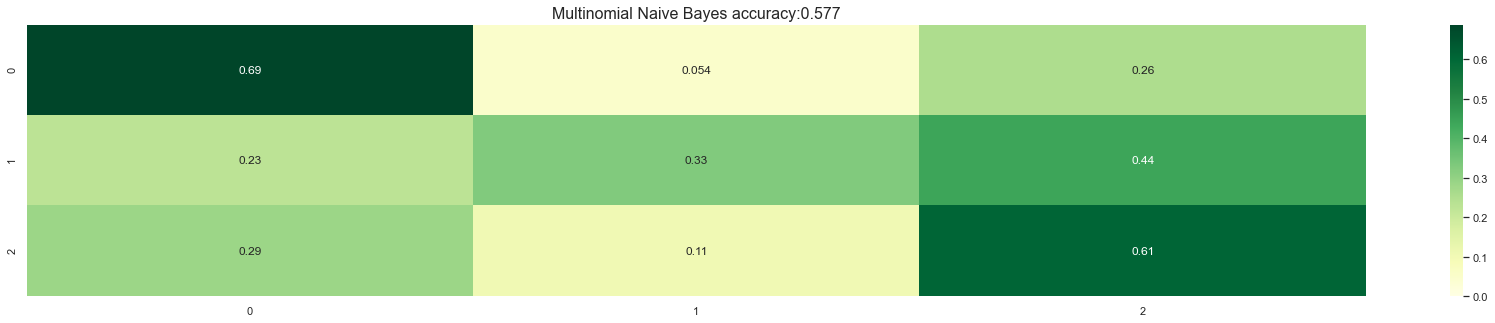

In [36]:
manage_results.make_confusion_matrices(Ytest, Y_MODELS, MODEL_NAMES)

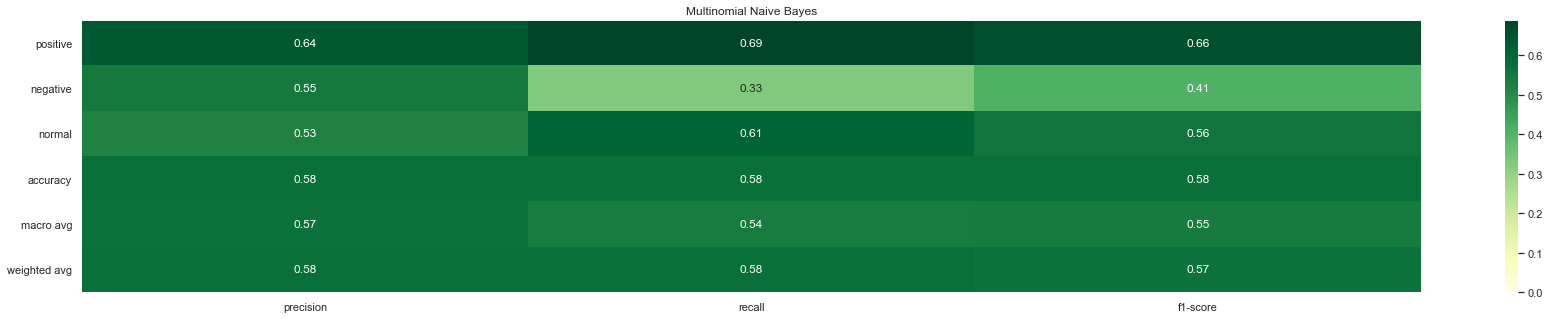

In [37]:
manage_results.make_classification_report(Ytest, Y_MODELS, MODEL_NAMES)

### Analyzing the wheights

Once the model has been trained, we can extract the weight that has given to each position of the embedded vector, so we can figure out how much or how less a word worth in the 'decision' that the model makes in order to assign a class to the given sample.<br>
We'll do this in two steps:
* Extract the weights creating a new dataframe that has the words as index and one column per class
* Plotting the results

In [38]:
multi_NB_params = manage_results.get_NB_weighted_df(idf, multi_NB_model, 'multinomial_NB')

/Users/alessandro/Documents/uni/magistrale/FDS/FDS2122/go_emotions/code/manage_results.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret[f'class_{i}_weights'+f'_{model_name}' if model_name != '' else ''] = model.feature_log_prob_[i, :]


In [39]:
multi_NB_params

,IDF,embedded_position,is_stopword,class_0_weights_multinomial_NB,class_1_weights_multinomial_NB,class_2_weights_multinomial_NB
hurt,5.972749,0,False,-8.413535,-7.138946,-8.133994
game,4.321156,1,False,-6.749303,-7.209604,-7.018209
that,1.780362,2,True,-5.197539,-5.100495,-5.145505
if,2.901793,3,True,-6.205674,-6.212530,-5.926229
then,3.939497,4,True,-6.945655,-6.735788,-6.369660
...,...,...,...,...,...,...
strain,9.333124,7776,False,-11.307532,-10.462990,-9.340384
profiles,9.333124,7777,False,-10.889804,-10.412981,-10.332734
landed,9.150803,7778,False,-10.169666,-10.263937,-10.428825
rubbing,9.333124,7779,False,-10.511982,-10.502211,-10.360393


In [40]:
WEIGHTED_IDFS = [multi_NB_params]

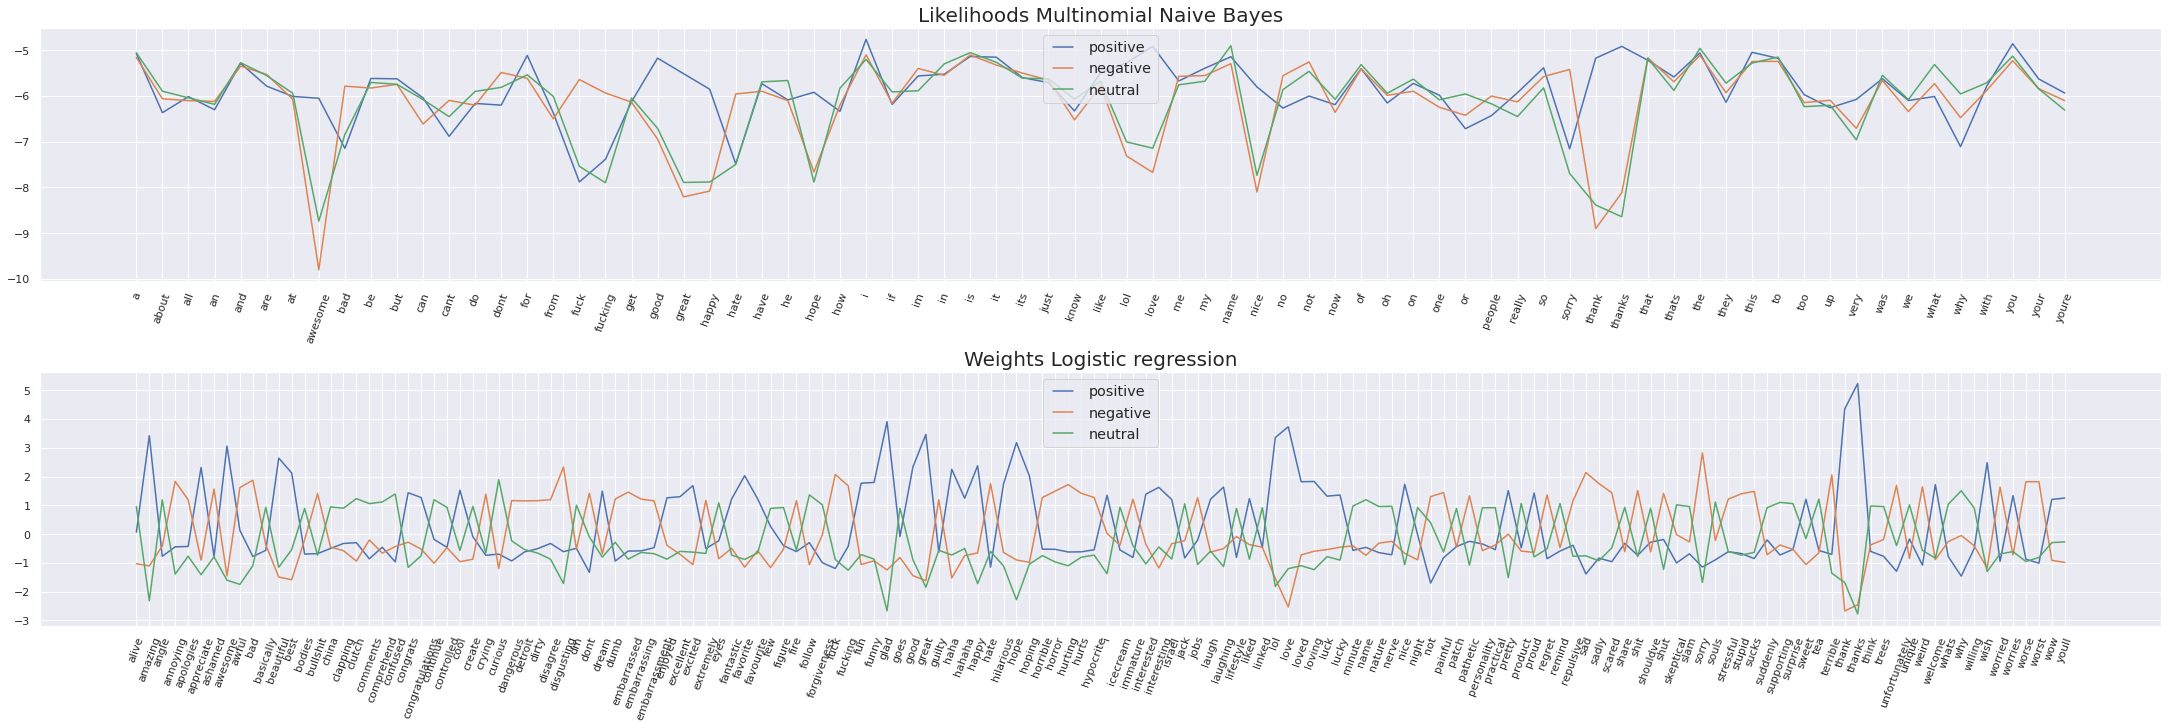

In [5]:
manage_results.get_weighted_plots_from_dir('csv_results_tfidf')

In [46]:
_, model_name, _, weighted_idf = manage_results.load_from_dir('to_be_plotted', only_weight=True)
weighted_idf = weighted_idf[0]

### Also the emoticons count!
In the following cell we've used a stored result in order to analyze whether the special characters count or not in the decision to classificate a comment as negative and we can see that there are many emoticons (the first is laughing maybe due to some bias, 'cause it can be used to make fun of other people).<br>
There are also 2nd and 3rd and maybe is due to the fact that when someone is classificated 2nd or 3rd can use not so beautiful words in order to express its emotions

In [47]:
nalpha = pd.Series(weighted_idf.index).apply(str.isalpha).values
nalpha = weighted_idf[~nalpha]
strange = nalpha[~pd.Series(nalpha.index).apply(str.isnumeric).values].iloc[:,-3:]
strange.sort_values(by='class_1_weights_multinomial_NB', ascending=False).head(20)


,class_0_weights_multinomial_NB,class_1_weights_multinomial_NB,class_2_weights_multinomial_NB
😂,-7.505414,-8.257248,-8.183114
2nd,-8.872238,-8.685125,-9.067340
🙄,-9.881765,-8.759553,-9.053280
😩,-10.898511,-9.066958,-10.082837
😔,-10.872410,-9.089514,-9.708608
😭,-9.627729,-9.166215,-10.275475
😢,-9.822596,-9.206672,-10.836603
🤣,-8.449822,-9.267278,-9.645871
3rd,-9.067549,-9.364661,-8.967686
🤢,-11.323322,-9.450752,-10.489619


#### Automating the overall process

In order to compute the test among several combination we've automated all the process thanks to the use of the [automatic execution](automatic_execution.py) tools that allows us to execute a test with a given combination of the preprocessing features and to store the result in the desired path

In [48]:
# The automated version of the just done execution (the results will be stored to the folder)
#       foo_savings/total_lower_case_stopwords

# I'ts commented in order to avoid overriding
# lower_stop = 'lower_case_stopwords'
# automatic_execution.exe(stopwords_path, 'foo_savings/total_'+lower_stop, lower=True, lemma=False)
print('Done')

Done


# Word2Vec

Word embeddings are words mapped to real number vectors such that it can capture the semantic meaning of words. The methods tried previously in this notebook such as BOW and TFIDF do not capture the meaning between the words, they consider the words seperately as features. Word embeddings use some models to map a word into vectors such that similar words will be closer to each other. As shown in the below figure, for example some of the positive words which are adjectives will be closer to each other and vice versa for negative adjectives. It captures semantical and syntactical information of words. To train this model it takes into consideration the words surrounding that word of particular window size. There are different ways of deriving the word embedding vectors. [Word2Vec](https://arxiv.org/abs/1301.3781) is one such method where neural embeddings model is used to learn that. It uses the following two architectures to achieve this:
- CBOW
- Skip Gram

![adjectives](https://miro.medium.com/max/662/1*tL_Oe_33S40oPqVTiR8CLA.png)

**CBOW (Continuous bag of words)**

Here the model predicts the word under consideration given context words within specific window. The hidden layer has the number of dimensions in which the current word needs to be represented at the output layer. Following diagram shows an example with window of size 2 for predicting vector for word "awesome" given the sentence "Restaurant was awesome this time".

![CBOW](https://miro.medium.com/max/700/1*fSg0IJEvDA4iBrLB7C2RpQ.png)

**Skip Gram**

Skip gram is the opposite of CBOW, it predicts embeddings for the surrounding context words in the specific window size given a current word. The input layer contains the current word and the output layer contains the context words. The hidden layer contains the number of dimensions in which we want to represent current word present at the input layer. Following shows an example with window size of 2.

![SG](https://miro.medium.com/max/700/1*MqoUdbWmPM8fQq8jzha-eg.png)

Credits from [here](https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca)

Tokenize the strings and remove empy sentences from dataset:

In [196]:
def tokenization(df): # Tokenize the text column
    df["text"] = df["text"].apply(lambda x: list(tokenize(x, deacc=True)))
    return preprocessing.remove_empty(df)

df = tokenization(df)
df.head()

,text,y
0,"[that, game, hurt]",1
2,"[you, do, right, if, you, do, not, care, then,...",2
3,"[man, I, love, reddit]",0
4,"[name, be, nowhere, near, they, he, be, by, the]",2
5,"[right, consider, its, such, an, important, do...",0


Train the Word2Vec model with our corpus and save it:

In [197]:
def train_w2v(df, vsize, sg):
    return Word2Vec(sentences=df["text"].values, min_count=1, vector_size=vsize, sg=sg) # sg = 0 CBOW model, sg = 1 Skip-gram model

w2v_model = train_w2v(df, 100, 1)

In [199]:
# Unique ID of the word
print("Index of the word 'action':")
print(w2v_model.wv.key_to_index["action"])

# Total number of the words 
print(len(w2v_model.wv))

# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(w2v_model.wv["action"]))

# Get the mean for the vectors for an example comment
print("Print the length after taking average of all word vectors in a sentence:")
print(len(np.mean([w2v_model.wv[token] for token in df["text"].iloc[0]], axis=0)))

Index of the word 'action':
853
6238
Length of the vector generated for a word
100
Print the length after taking average of all word vectors in a sentence:
100


Obtain the embedding for every sentence in our dataset:

In [5]:
# Store the vectors for dataset in following file, stores one row at a time to avoid memory overload due to big dataframe loading
def save_dataset(filename, w2v_model):
    with open(filename, 'w+') as word2vec_file:
        header = ",".join([str(i) for i in range(len(w2v_model.wv["action"]))])
        word2vec_file.write(header+",y")
        word2vec_file.write('\n')
        for sentence,ground in zip(df["text"],df["y"]):
            model_vector = (np.mean([w2v_model.wv[token] for token in sentence], axis=0)).tolist()
            line = ",".join([str(vector_element) for vector_element in model_vector])
            word2vec_file.write(line+","+str(ground))
            word2vec_file.write('\n')

In [1]:
word2vec_filename = 'w2v1000SG/dataset_w2v1000_nofreq_lemmatiz.csv'
#save_dataset(word2vec_filename, w2v_model)

Load the data and obtain train and test sets:

In [3]:
# Train Test Split Function
def split_data(X,y):
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load from the filename
data = pd.read_csv(word2vec_filename)
X_train, X_test, y_train, y_test = split_data(data.iloc[:,:-1], data["y"])
X_train.shape, y_train.shape

((45405, 1000), (45405,))

## Logistic Regression

First we perform hyperparameter tuning with cross validation in order to evaluate the best model:

In [166]:
#Hyperparameter tuning and 5-fold cross validation in order to evaluate the best model
lr = GridSearchCV(LogisticRegression(multi_class="multinomial"), {
    "penalty" : ["l2", "none"],
    "max_iter" : [500, 1000, 2000]
}, cv=5, return_train_score=False)

start_time = time.time()
#Fit the model
lr.fit(X_train, y_train)
print("Time taken to find the best LR model with word2vec vectors: " + str(time.time() - start_time))
pd.DataFrame(lr.cv_results_)[["params","mean_test_score"]]

Time taken to find the best LR model with word2vec vectors: 590.2385878562927


,params,mean_test_score
0,"{'max_iter': 500, 'penalty': 'l2'}",0.536543
1,"{'max_iter': 500, 'penalty': 'none'}",0.541487
2,"{'max_iter': 1000, 'penalty': 'l2'}",0.536214
3,"{'max_iter': 1000, 'penalty': 'none'}",0.543157
4,"{'max_iter': 2000, 'penalty': 'l2'}",0.536214
5,"{'max_iter': 2000, 'penalty': 'none'}",0.544278


Then we use the best model:

In [2]:
#Istantiate the best model
best_lr = LogisticRegression(multi_class="multinomial", **lr.best_params_)

start_time = time.time()
#Fit the model
best_lr.fit(X_train, y_train)
print("Time taken to fit the LR model with word2vec vectors: " + str(time.time() - start_time))

def testModel(X,y,model):
    y_hat = model.predict(X)
    print(classification_report(y, y_hat))
    cmat = confusion_matrix(y, y_hat, normalize="true")
    ax= plt.subplot()
    sns.heatmap(cmat, annot=True, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

For Word2Vec model's features with vector_size=100, CBOW architecture and using Logistic Regression, we obtained the best accuracy **(0.55)** with many preprocessing combinations: lemmatization, lemmatization and removed low frequency words, lowercase and removed low frequency words, lowercase no stopwords and removed low frequency words. For shortening the notebook here we just report the results of one we have chosen to keep, but all the experiments are reproducible as we attach the already embedded datasets in w2v100CBOW folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and also stopwords removed, because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on.

              precision    recall  f1-score   support

           0       0.65      0.62      0.64      4566
           1       0.48      0.18      0.26      2564
           2       0.49      0.70      0.57      4169

    accuracy                           0.55     11299
   macro avg       0.54      0.50      0.49     11299
weighted avg       0.55      0.55      0.53     11299



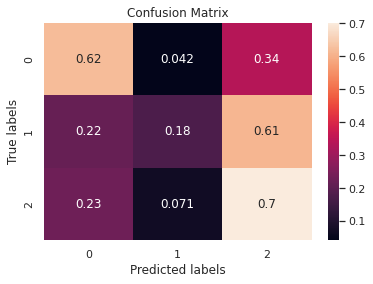

In [118]:
testModel(X_test, y_test, best_lr) #test w\ Word2Vec model with vector_size=100, lowercase, no low frequency words and no stopwords (punctuation is always removed)

For Word2Vec model's features with vector_size=1000, CBOW architecture and using Logistic Regression, we obtained the best accuracy **(0.57)** with many preprocessing combinations: lowercase and no stopwords, lowercase no stopwords and lemmatization, lowercase no stopwords and removed low frequency words, lowercase and removed low frequency words, lowercase removed low frequency words and lemmatization. For shortening the notebook here we just report the results of one we have chosen to keep, but all the experiments are reproducible as we attach the already embedded datasets in w2v1000CBOW folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and applied lemmatization, because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on. So with a feature vector size of 10x the default we get an increase of 0.02 in accuracy.

              precision    recall  f1-score   support

           0       0.66      0.66      0.66      4575
           1       0.52      0.22      0.31      2570
           2       0.51      0.69      0.59      4207

    accuracy                           0.57     11352
   macro avg       0.56      0.52      0.52     11352
weighted avg       0.57      0.57      0.55     11352



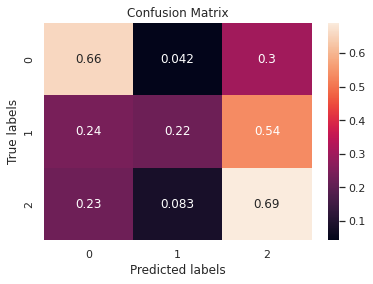

In [159]:
testModel(X_test, y_test, best_lr) # test with Word2Vec model with vector_size=1000, lowercase, removed low frequencies and lemmatization

For Word2Vec model's features with vector_size=100, SG architecture and using Logistic Regression, we obtained the best accuracy **(0.57)** with many preprocessing combinations: only lemmatization, lowercase removed low frequency words and lemmatization, lowercase no stopwords and lemmatization, lowercase and removed low frequency words. For shortening the notebook here we just report the results of one we have chosen to keep, but all the experiments are reproducible as we attach the already embedded datasets in w2v100SG folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and lemmatization, because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on.

              precision    recall  f1-score   support

           0       0.64      0.67      0.65      4575
           1       0.51      0.22      0.31      2570
           2       0.51      0.67      0.58      4207

    accuracy                           0.57     11352
   macro avg       0.56      0.52      0.51     11352
weighted avg       0.56      0.57      0.55     11352



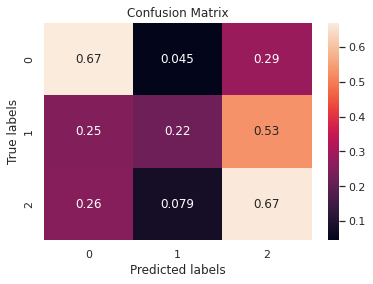

In [150]:
testModel(X_test, y_test, best_lr) # test with Word2Vec model with vector_size=100, lowercase, removed low frequencies and lemmatization

For Word2Vec model's features with vector_size=1000, SG architecture and using Logistic Regression, we obtained the best accuracy **(0.60)** with many preprocessing combinations: lowercase removed low frequency words and lemmatization, lowercase no stopwords and lemmatization, lowercase and removed low frequency words. For shortening the notebook here we just report the results of one we have chosen to keep, but all the experiments are reproducible as we attach the already embedded datasets in w2v1000SG folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and lemmatization, because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on. **This model turns out to be the best for Logistic Regression, and Logistic Regression turns out to be a better algorithm than Naive Bayes for this task and with this feature modeling.** Here we also notice that increasing the size of the vector of 10 times produced a good improvement, especially in the negative sentiment class. That's probably due to the fact that the Word2Vec model can separate better between 3 classes if the feature vectors are bigger.

              precision    recall  f1-score   support

           0       0.69      0.68      0.68      4575
           1       0.57      0.31      0.40      2570
           2       0.53      0.69      0.60      4207

    accuracy                           0.60     11352
   macro avg       0.60      0.56      0.56     11352
weighted avg       0.60      0.60      0.59     11352



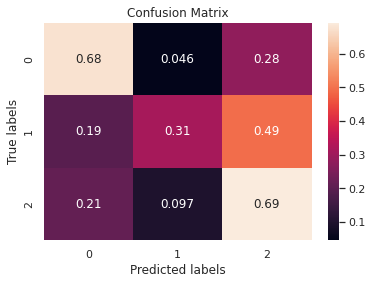

In [155]:
testModel(X_test, y_test, best_lr) # test with Word2Vec model with vector_size=1000, lowercase, removed low frequencies and lemmatization

The following is the code used for testing Logistic Regression models:

In [168]:
cbow100 = {}
cbow1000 = {}
sg100 = {}
sg1000 = {}

for architecture in [0,1]:
    for vecsize in [100,1000]:
        for prep in ["lcase_nofreq","lcase_nostop_lemmatiz","lcase_nostop_nofreq","lcase_nostop","lcase","lemmatiz","nofreq_lemmatiz","nofreq","original"]:
            df = basicprocessing(DATASET_PATH)
            
            if "lcase" in prep:
                preprocessing.lower_case(df)
            if "nostop" in prep:
                preprocessing.remove_stopwords(df)
            if "lemmatiz" in prep:
                preprocessing.lemmatize(df)
            if "nofreq" in prep:
                df = preprocessing.remove_lessfreq(df)
            
            df = tokenization(df)
            w2v_model = train_w2v(df,vecsize,architecture)
            
            if architecture == 0:
                filename = "w2v"+str(vecsize)+"CBOW/dataset_w2v"+str(vecsize)+"_"+prep+".csv"
            else:
                filename = "w2v"+str(vecsize)+"SG/dataset_w2v"+str(vecsize)+"_"+prep+".csv"
                
            save_dataset(filename, w2v_model)

            data = pd.read_csv(filename)
            X_train, X_test, y_train, y_test = split_data(data.iloc[:,:-1], data["y"])

            #Istantiate the best model
            best_lr = LogisticRegression(multi_class="multinomial", **lr.best_params_)
            #Fit the model
            best_lr.fit(X_train, y_train)

            y_hat = best_lr.predict(X_test)
            if vecsize == 100:
                if architecture == 0: cbow100[prep] = accuracy_score(y_test, y_hat)
                else: sg100[prep] = accuracy_score(y_test, y_hat)
            else:
                if architecture == 0: cbow1000[prep] = accuracy_score(y_test, y_hat)
                else: sg1000[prep] = accuracy_score(y_test, y_hat)  

print("cbow"+str(100))
print(cbow100)
print()
print("cbow"+str(1000))
print(cbow1000)
print()
print("sg"+str(100))
print(sg100)
print()
print("sg"+str(1000))
print(sg1000)

cbow100
{'lcase_nofreq': 0.545910731578484, 'lcase_nostop_lemmatiz': 0.5569742867206763, 'lcase_nostop_nofreq': 0.5494291530223914, 'lcase_nostop': 0.558295174357168, 'lcase': 0.5446475654772368, 'lemmatiz': 0.5518544559676569, 'nofreq_lemmatiz': 0.5484496124031008, 'nofreq': 0.5312472454825915, 'original': 0.5349797855510634}

cbow1000
{'lcase_nofreq': 0.5724095430935822, 'lcase_nostop_lemmatiz': 0.5693025713279324, 'lcase_nostop_nofreq': 0.5725285423488804, 'lcase_nostop': 0.5664846777034167, 'lcase': 0.5639831253295834, 'lemmatiz': 0.5636315696959043, 'nofreq_lemmatiz': 0.5707364341085271, 'nofreq': 0.5553107095636844, 'original': 0.5443838987519775}

sg100
{'lcase_nofreq': 0.5654547055198521, 'lcase_nostop_lemmatiz': 0.5699189855582951, 'lcase_nostop_nofreq': 0.5601380653155147, 'lcase_nostop': 0.5639309616061994, 'lcase': 0.5591492353664967, 'lemmatiz': 0.56521357004746, 'nofreq_lemmatiz': 0.5665081042988019, 'nofreq': 0.5546055531070956, 'original': 0.5588855686412375}

sg1000
{'

## Naive Bayes
MultinomialNB assumes that features have multinomial distribution which is a generalization of the binomial distribution. Neither binomial nor multinomial distributions can contain negative values. Also, MultinomialNB is designed for classification with discrete features, meanwhile with word embeddings we have continuous features. That's why here we will use GaussianNB. Since this algorithm doesn't have any relevant hyperparameter to tune, we just proceed by training and testing our model:

In [190]:
#Istantiate the best model
nb = naive_bayes.GaussianNB()

start_time = time.time()
#Fit the model
nb.fit(X_train, y_train)
print("Time taken to fit the NB model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the NB model with word2vec vectors: 0.41783857345581055


For Word2Vec model's features with vector_size=100, CBOW architecture and using Naive Bayes, we obtained the best accuracy **(0.44)** with lowercasing the dataset, removing stopwords and doing lemmatization. For shortening the notebook here we just report the results of this experiment, but all the experiments are reproducible as we attach the already embedded datasets in w2v100CBOW folder. **Naive Bayes, in general, turns out to be a worse method than Logistic Regression for this task and with Word2Vec's feature modeling. That's probably due to the fact that Naive Bayes takes the assumption of the independence of the features, meanwhile in the sentiment analysis task of course that's not true, since the sentence has related words in it.**

              precision    recall  f1-score   support

           0       0.57      0.48      0.52      4576
           1       0.29      0.45      0.35      2570
           2       0.46      0.39      0.42      4210

    accuracy                           0.44     11356
   macro avg       0.44      0.44      0.43     11356
weighted avg       0.47      0.44      0.45     11356



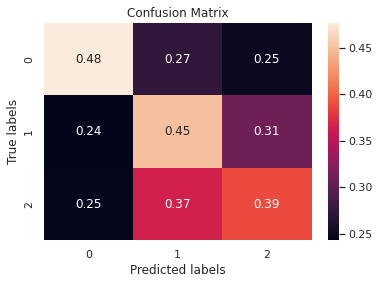

In [178]:
testModel(X_test, y_test, nb)

For Word2Vec model's features with vector_size=1000, CBOW architecture and using Naive Bayes, we obtained the best accuracy **(0.44)** with lowercasing the dataset, removing stopwords and doing lemmatization. For shortening the notebook here we just report the results of this experiment, but all the experiments are reproducible as we attach the already embedded datasets in w2v1000CBOW folder. Here we notice that increasing the size of the vector of 10 times didn't produce any improvement at all.

              precision    recall  f1-score   support

           0       0.55      0.51      0.53      4576
           1       0.29      0.44      0.35      2570
           2       0.46      0.36      0.41      4210

    accuracy                           0.44     11356
   macro avg       0.44      0.44      0.43     11356
weighted avg       0.46      0.44      0.44     11356



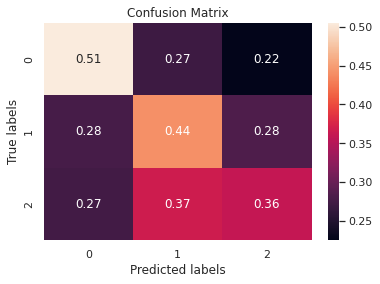

In [182]:
testModel(X_test, y_test, nb)

For Word2Vec model's features with vector_size=100, SG architecture and using Naive Bayes, we obtained the best accuracy **(0.45)** with both: only removing low frequency words; lowercase, removed stopwords and removed low frequency words. For shortening the notebook here we just report the results of the latter, but all the experiments are reproducible as we attach the already embedded datasets in w2v100SG folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and removed stopwords, because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on.

              precision    recall  f1-score   support

           0       0.61      0.41      0.49      4566
           1       0.32      0.51      0.39      2564
           2       0.46      0.45      0.45      4169

    accuracy                           0.45     11299
   macro avg       0.46      0.46      0.45     11299
weighted avg       0.49      0.45      0.46     11299



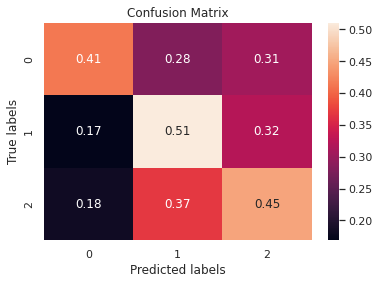

In [186]:
testModel(X_test, y_test, nb) # lowercase, removed stopwords and removed low frequency words

For Word2Vec model's features with vector_size=1000, SG architecture and using Naive Bayes, we obtained the best accuracy **(0.44)** with: only removing low frequency words; lowercase, removed stopwords and lemmatization; lowercase and removed stopwords; lowercase, removed low frequency words and removed stopwords. For shortening the notebook here we just report the results of the latter, but all the experiments are reproducible as we attach the already embedded datasets in w2v1000SG folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and removed stopwords because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on. Here we notice again that increasing the size of the vector of 10 times didn't produce any improvement at all.

              precision    recall  f1-score   support

           0       0.62      0.42      0.50      4566
           1       0.30      0.58      0.40      2564
           2       0.47      0.37      0.41      4169

    accuracy                           0.44     11299
   macro avg       0.46      0.46      0.44     11299
weighted avg       0.49      0.44      0.45     11299



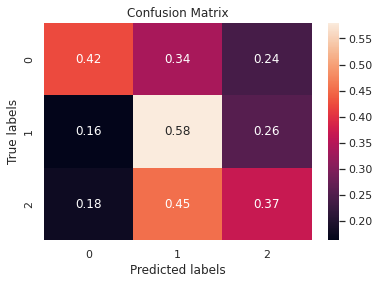

In [191]:
testModel(X_test, y_test, nb)

In [171]:
cbow100 = {}
cbow1000 = {}
sg100 = {}
sg1000 = {}

for architecture in [0,1]:
    for vecsize in [100,1000]:
        for prep in ["lcase_nofreq","lcase_nostop_lemmatiz","lcase_nostop_nofreq","lcase_nostop","lcase","lemmatiz","nofreq_lemmatiz","nofreq","original"]:
            
            if architecture == 0:
                filename = "w2v"+str(vecsize)+"CBOW/dataset_w2v"+str(vecsize)+"_"+prep+".csv"
            else:
                filename = "w2v"+str(vecsize)+"SG/dataset_w2v"+str(vecsize)+"_"+prep+".csv"

            data = pd.read_csv(filename)
            X_train, X_test, y_train, y_test = split_data(data.iloc[:,:-1], data["y"])

            #Istantiate the best model
            nb = naive_bayes.GaussianNB()
            #Fit the model
            nb.fit(X_train, y_train)

            y_hat = nb.predict(X_test)
            if vecsize == 100:
                if architecture == 0: cbow100[prep] = accuracy_score(y_test, y_hat)
                else: sg100[prep] = accuracy_score(y_test, y_hat)
            else:
                if architecture == 0: cbow1000[prep] = accuracy_score(y_test, y_hat)
                else: sg1000[prep] = accuracy_score(y_test, y_hat)  

print("cbow"+str(100))
print(cbow100)
print()
print("cbow"+str(1000))
print(cbow1000)
print()
print("sg"+str(100))
print(sg100)
print()
print("sg"+str(1000))
print(sg1000)

cbow100
{'lcase_nofreq': 0.4234527687296417, 'lcase_nostop_lemmatiz': 0.43791828108488906, 'lcase_nostop_nofreq': 0.4210992123196743, 'lcase_nostop': 0.42488552307150407, 'lcase': 0.42828265072947796, 'lemmatiz': 0.41993320442960097, 'nofreq_lemmatiz': 0.41331923890063427, 'nofreq': 0.43032172763331866, 'original': 0.42828265072947796}

cbow1000
{'lcase_nofreq': 0.414473105026851, 'lcase_nostop_lemmatiz': 0.4366854526241634, 'lcase_nostop_nofreq': 0.41437295335870433, 'lcase_nostop': 0.4205706234589644, 'lcase': 0.4186148708033046, 'lemmatiz': 0.41149586922130427, 'nofreq_lemmatiz': 0.41014799154334036, 'nofreq': 0.41851035698545613, 'original': 0.4190543153454034}

sg100
{'lcase_nofreq': 0.43340082753763537, 'lcase_nostop_lemmatiz': 0.44029587883057414, 'lcase_nostop_nofreq': 0.4487122754226038, 'lcase_nostop': 0.44135258893976753, 'lcase': 0.4285463174547372, 'lemmatiz': 0.4110564246792055, 'nofreq_lemmatiz': 0.42177589852008457, 'nofreq': 0.4501542529748788, 'original': 0.4387414308

## Feature analysis

One thing to notice is that the total input dimension in Word2Vec respect to BOW and TF-IDF has reduced from vocab size to 100 or 1000 (hyperparameter). That is here the dimension can be made custom, but as it is capturing the necessary things and only limited things to describe the words it is a good compromise between accuracy and computational complexity for the classification model. From now we only consider the best model for feature analysis, which is the one with 60% accuracy.

**Principal component analysis**: it doesn't tell us anything interesting except the fact that the dataset is really hard to embed, and therefore also to predict.

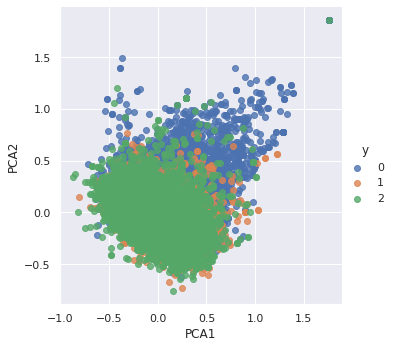

In [ ]:
model = PCA(n_components=2)
model.fit(X_train)
X_2D = pd.DataFrame(model.transform(X_train), columns=["PCA1", "PCA2"])
X_2D = X_2D.assign(y=pd.Series(y_train).values) # in order to reset index
sns.lmplot(x="PCA1", y="PCA2", hue="y", data=X_2D, fit_reg=False);

**Correlation matrix:** we can see that some of the features are correlated.

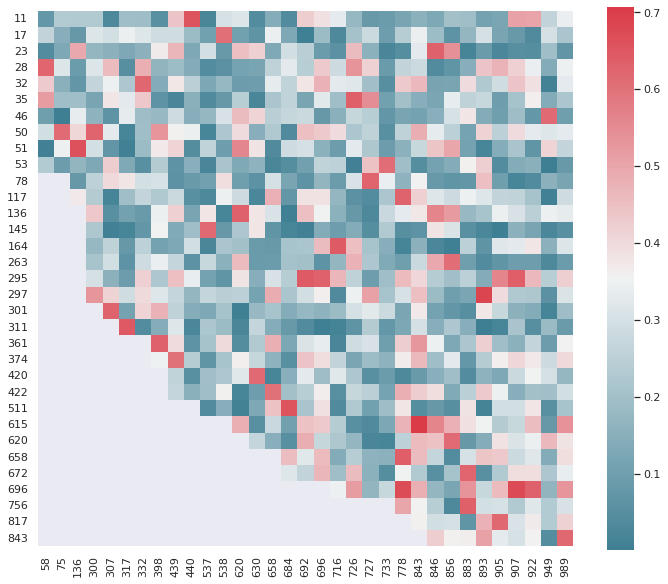

In [41]:
corr_mat = data.iloc[:,:-1].corr().abs()
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(np.bool))
upper_tri = upper_tri[(upper_tri >= 0.6).any(axis=1)]
upper_tri = upper_tri.loc[:,(upper_tri >= 0.6).any(axis=0)]

_, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(upper_tri, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax);

Here we give a try to modeling polynomial features and performing polynomial logistic regression. Other than the fact that it takes much more time to train, it doesn't take us any improvement, instead we dropped from 0.57 to 0.55 accuracy (it was performed on the best dataset generated by the Word2Vec model with vector_size=100 and SG architecture, due to computational complexity issues).

In [51]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

clf = LogisticRegression(multi_class="multinomial", max_iter=2000, penalty="none")
clf.fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))

0.5556730091613813


# BoW (Bag of Words)

<a href="https://machinelearningmastery.com/gentle-introduction-bag-words-model/">Bag of Words</a> is a way of extracting features from text, in particular we consider the frequency wherewith a single word occurs in the sentencte. 
It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

## Example data
Let’s say we have a set $D$ of 2 documents:

$D$ = {“it was the best of times, it was the worst of times”, “it was the age of wisdom, it was the age of foolishness”}

Now we make a set $W$ of all of the words that are present in the set $D$:

$W$ = {“age”, “best”, “foolishness”, “it”, “of”, “the”, “times”, “was”, “wisdom”, “worst”}

And then, finally, we can create a set $X$ of document vectors (the cell $X_{ij}$ indicates how many times the word $j$ appears in the document $i$):

|   | $w_1$ | $w_2$ | $w_3$ | $w_4$ | $w_5$ | $w_6$ | $w_7$ | $w_8$ | $w_9$ | $w_{10}$ |
|---|---|---|---|---|---|---|---|---|---|---|
| $d_1$ | 0 | 1 | 0 | 2 | 2 | 2 | 2 | 2 | 0 | 1 |
| $d_2$ | 2 | 0 | 1 | 2 | 2 | 2 | 0 | 2 | 1 | 0 |

In [ ]:
def get_data(df):
    comments = []
    for c in df['text']:
        comments.append(c)
    vectorizer = CountVectorizer(lowercase=False)
    X = vectorizer.fit_transform(comments)
    return vectorizer.get_feature_names(), X.toarray().astype(np.int32), df[['y']].to_numpy(dtype='uint8').T[0]  

In [ ]:
feature_names, X, y = get_data(df)
X_train, X_test, y_train, y_test = split_data(X,y)
X_train.shape, y_train.shape

((45442, 7694), (45442,))

In [ ]:
def get_words(df, feature_names):
    words = []
    for row in df['text']:
        words += row.split(' ')
    return [w for w in words if w in feature_names]

df_words = pd.DataFrame(list(OrderedDict.fromkeys(get_words(df, feature_names))), columns=['word'])
df_words = df_words.set_index('word')
df_words.head()

""
word
game
hurt
that
do
care


## Naive Bayes

In [ ]:
multi_NB_model = naive_bayes.MultinomialNB()
multi_NB_model = multi_NB_model.fit(X_train, y_train)

Below are shown some tables with precision, recall and accuracy for each group of sentiment

              precision    recall  f1-score   support

           0       0.66      0.71      0.68      4567
           1       0.54      0.43      0.48      2564
           2       0.54      0.56      0.55      4172

    accuracy                           0.59     11303
   macro avg       0.58      0.57      0.57     11303
weighted avg       0.59      0.59      0.59     11303



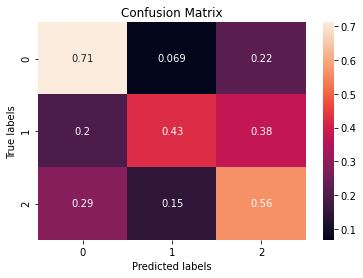

In [ ]:
# with naive bayes method, wihout stop words and with text in lower case

testModel(X_test,y_test,multi_NB_model)

              precision    recall  f1-score   support

           0       0.66      0.73      0.69      4575
           1       0.55      0.42      0.48      2571
           2       0.57      0.59      0.58      4215

    accuracy                           0.61     11361
   macro avg       0.59      0.58      0.58     11361
weighted avg       0.60      0.61      0.60     11361



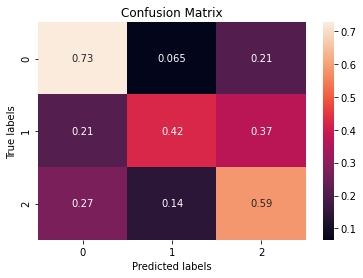

In [ ]:
# with naive bayes method, with stop words and with text in lower case

testModel(X_test,y_test,multi_NB_model)

              precision    recall  f1-score   support

           0       0.67      0.70      0.68      4573
           1       0.54      0.45      0.49      2570
           2       0.56      0.59      0.57      4204

    accuracy                           0.60     11347
   macro avg       0.59      0.58      0.58     11347
weighted avg       0.60      0.60      0.60     11347



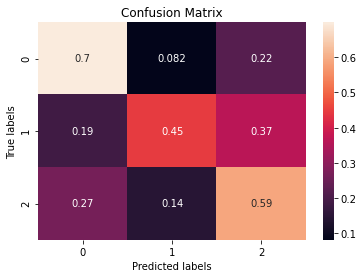

In [ ]:
# with naive bayes method, with stop words and without text in lower case

testModel(X_test,y_test,multi_NB_model)

              precision    recall  f1-score   support

           0       0.67      0.70      0.68      4573
           1       0.57      0.43      0.49      2570
           2       0.55      0.60      0.58      4204

    accuracy                           0.60     11347
   macro avg       0.60      0.58      0.58     11347
weighted avg       0.60      0.60      0.60     11347



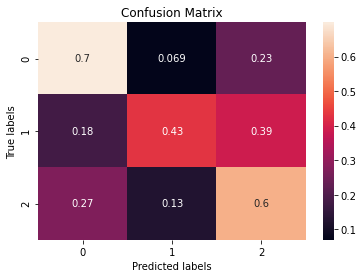

In [ ]:
# with Naive Bayes method and lemmatization

testModel(X_test,y_test,multi_NB_model)

## Logistic regression

In [ ]:
lr_model = LogisticRegression(multi_class='multinomial', max_iter=1000)
lr_model = lr_model.fit(X_train, y_train)

Below are shown some tables with precision, recall and accuracy for each group of sentiment

              precision    recall  f1-score   support

           0       0.71      0.68      0.69      4567
           1       0.55      0.45      0.49      2564
           2       0.56      0.65      0.60      4172

    accuracy                           0.62     11303
   macro avg       0.61      0.59      0.60     11303
weighted avg       0.62      0.62      0.61     11303



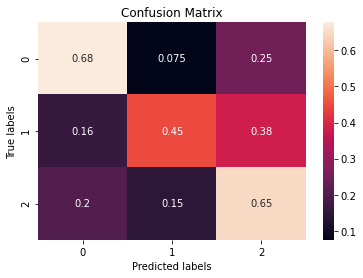

In [ ]:
# with logistic regression method, wihout stop words and with text in lower case

testModel(X_test,y_test,lr_model)

              precision    recall  f1-score   support

           0       0.71      0.70      0.70      4575
           1       0.56      0.46      0.50      2571
           2       0.57      0.65      0.61      4215

    accuracy                           0.62     11361
   macro avg       0.61      0.60      0.60     11361
weighted avg       0.62      0.62      0.62     11361



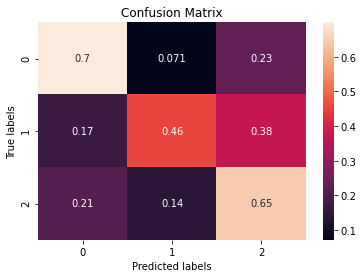

In [ ]:
# with logistic regression method, with stop words and with text in lower case

testModel(X_test,y_test,lr_model)

              precision    recall  f1-score   support

           0       0.71      0.67      0.69      4573
           1       0.54      0.47      0.50      2570
           2       0.56      0.64      0.60      4204

    accuracy                           0.61     11347
   macro avg       0.60      0.59      0.60     11347
weighted avg       0.62      0.61      0.61     11347



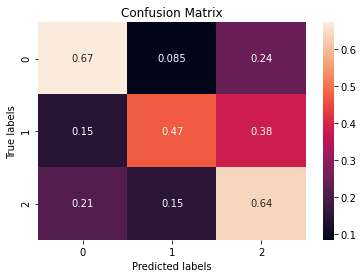

In [ ]:
# with logistic regression method, with stop words and without text in lower case

testModel(X_test,y_test,lr_model)

              precision    recall  f1-score   support

           0       0.72      0.67      0.70      4573
           1       0.56      0.46      0.50      2570
           2       0.56      0.66      0.61      4204

    accuracy                           0.62     11347
   macro avg       0.61      0.60      0.60     11347
weighted avg       0.62      0.62      0.62     11347



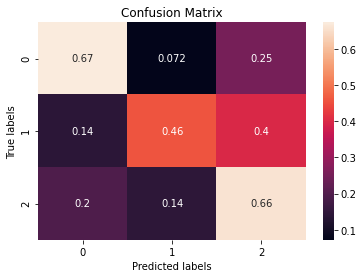

In [ ]:
# with logistic regression method and lemmatization

testModel(X_test,y_test,lr_model)

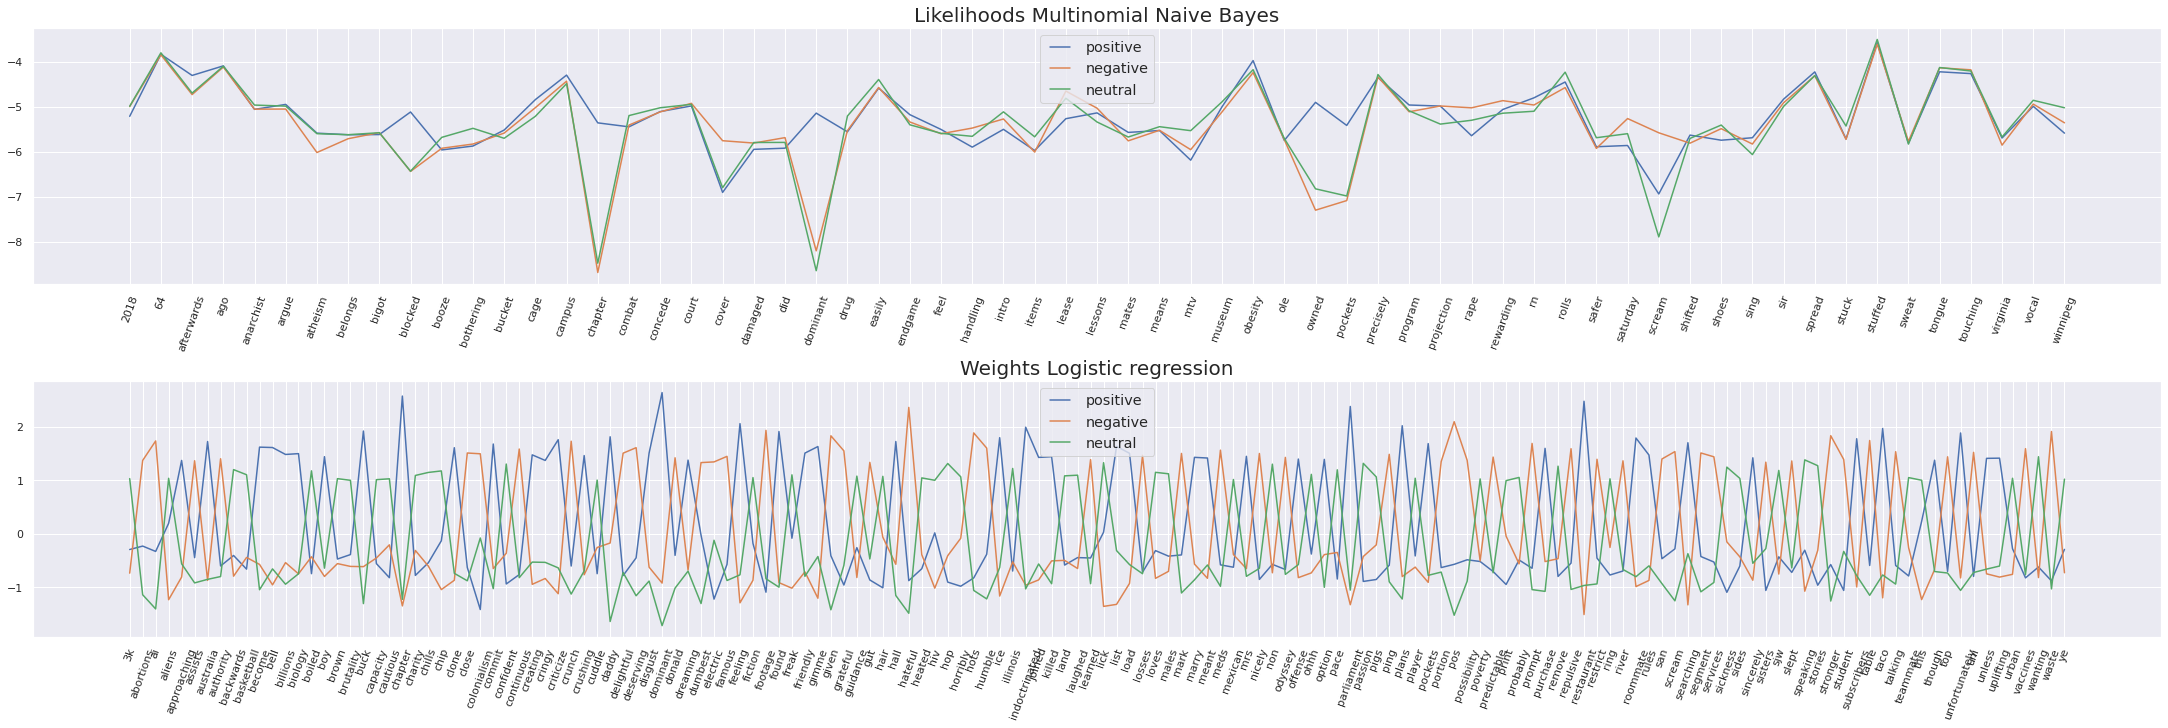

In [6]:
manage_results.get_weighted_plots_from_dir('csv_results_bow')